<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Dask and MapReduce

In the previous notebook, we learned how to read data with Dask, but we found that it was not faster than pandas or cuDF for a single file. In this lab, we will learn how to use Dask to speed up computation under the correct conditions.

## Objectives
* Learn when to use Dask
* Learn the basics of MapReduce
 
First, let's get these libraries loaded.

In [1]:
import cudf
import dask.dataframe as dd
import dask_cudf
import glob
import pandas as pd
import time
import urllib

class Timer:
    def __enter__(self):
        self.start = time.perf_counter()
        return self
    
    def __exit__(self, *args):
        self.end = time.perf_counter()
        self.interval = self.end - self.start

## Dask for Big Data

Neither pandas or cuDF can read in multiple CSV files directly with [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). In order to read multiple files into a DataFrame, we would need to loop through each file and append them together.

To see this, let's pull a couple more files from the [Water Level Website](https://tidesandcurrents.noaa.gov/stations.html?type=Water+Levels). This time, we will request a CSV and save it with the [urllib.request](https://docs.python.org/3/library/urllib.request.html).

**TODO**: Pull 2 more stations of data with the [CO-OPS API](https://api.tidesandcurrents.noaa.gov/api/prod/). In the event the website is down, we have saved sample data into [data/sample_data2.csv](data/sample_data2.csv) and [data/sample_data3.csv](data/sample_data3.csv)

In [4]:
url_base = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?"

station_id = "9452210"

url_parameters = {
    "station": station_id,
    "range": 365 * 24,  # 1 year of data.
    "product": "water_level",
    "units": "english",
    "datum": "MLLW",
    "time_zone": "gmt",
    "application": "ports_screen",
    "format": "csv"
}

url = url_base + urllib.parse.urlencode(url_parameters)
urllib.request.urlretrieve(url, "data/" + station_id + ".csv")

('data/9452210.csv', <http.client.HTTPMessage at 0x7f756ae3dad0>)

We should now have a few `.csv` files in the `data` folder. When referencing these files, we could type out the paths of each of these files individually, but instead, we will use the [glob](https://docs.python.org/3/library/glob.html) library to programmatically do this for us. We can use `*` as a wild card to filter files that match our pattern specified like so:

In [5]:
file_paths = glob.glob("data/*.csv")
file_paths = [file for file in file_paths if file != "data/numbers.csv"]
file_paths

['data/9450460.csv',
 'data/8735180.csv',
 'data/sample_data3.csv',
 'data/sample_data2.csv',
 'data/9452210.csv']

Each path starts with `data`, ends with `.csv`, and the `*` indicates to pick up anything in between. Let's set up a for loop to see how long it takes to read all of these files. Run the block **twice** to see how much faster cuDF is after it has been initialized.

In [7]:
usecols = [0, 1, 2]  # Column names are different when pulling csv directly


def read_all(library, file_paths):
    df_list = []
    for file in file_paths:
        df = library.read_csv(
            file, index_col=None, header=None, usecols=usecols, skiprows=1
        )
        df_list.append(df)
    return library.concat(df_list, axis=0, ignore_index=True)


with Timer() as t_pd:
    df_cpu = read_all(pd, file_paths)
with Timer() as t_cudf:
    df_gpu = read_all(cudf, file_paths)
"{:10s} pd: {:>8.5f}s cudf: {:>8.5f}s".format("csv", t_pd.interval, t_cudf.interval)

'csv        pd:  0.27950s cudf:  0.03543s'

Since Dask is made to be parallel, we do not need a for loop. It can read multiple files natively.

**TODO**: The below code shows how to read data in parallel. As we might remember from the previous notebook, this only sets up the process to read the files. Uncomment the two `FIXME` lines and replace the `FIXME` with the correct method to force Dask to *compute* a result.

In [8]:
with Timer() as t_dd_cpu:
    ddf_cpu = dd.read_csv(file_paths, usecols=usecols, header=0, skipinitialspace=True)
    ddf_cpu.compute()
with Timer() as t_dd_gpu:
    ddf_gpu = dask_cudf.read_csv(file_paths, usecols=usecols, header=0)
    ddf_gpu.compute()
    # skipinitialspace not supported in dask_cudf
    ddf_gpu.columns = ["Date Time", "Water Level", "Sigma"]
"{:10s} CPU: {:>8.5f}s GPU: {:>8.5f}s".format(
    "csv(dask)", t_dd_cpu.interval, t_dd_gpu.interval
)

'csv(dask)  CPU:  0.23162s GPU:  0.04836s'

In [ ]:
with Timer() as t_dd_cpu:
    ddf_cpu = dd.read_csv(file_paths, usecols=usecols, header=0, skipinitialspace=True)
    ddf_cpu.compute()
with Timer() as t_dd_gpu:
    ddf_gpu = dask_cudf.read_csv(file_paths, usecols=usecols, header=0)
    ddf_gpu.compute()
    # skipinitialspace not supported in dask_cudf
    ddf_gpu.columns = ["Date Time", "Water Level", "Sigma"]
"{:10s} CPU: {:>8.5f}s GPU: {:>8.5f}s".format(
    "csv(dask)", t_dd_cpu.interval, t_dd_gpu.interval
)

Let's sample our data to confirm it had been read correctly. This time, we will only be working with the first three columns of data.

In [9]:
%%time
ddf_cpu.head()

CPU times: user 52 ms, sys: 16 ms, total: 68 ms
Wall time: 64.6 ms


,Date Time,Water Level,Sigma
0,2022-10-22 22:24,9.031,0.105
1,2022-10-22 22:30,8.697,0.112
2,2022-10-22 22:36,8.355,0.102
3,2022-10-22 22:42,8.047,0.102
4,2022-10-22 22:48,7.712,0.105


In [10]:
%%time
ddf_gpu.head()

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 11.5 ms


,Date Time,Water Level,Sigma
0,2022-10-22 22:24,9.031,0.105
1,2022-10-22 22:30,8.697,0.112
2,2022-10-22 22:36,8.355,0.102
3,2022-10-22 22:42,8.047,0.102
4,2022-10-22 22:48,7.712,0.105


How can Dask do this faster than regular pandas or cuDF? Under the hood, Dask is building a system of operations called a DAG. We can view this DAG with the [visualize](https://docs.dask.org/en/latest/graphviz.html) method.

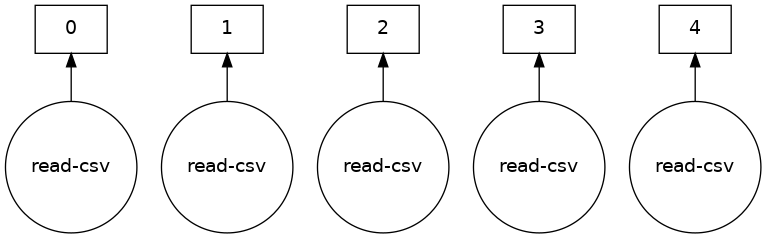

In [11]:
ddf_cpu.visualize()

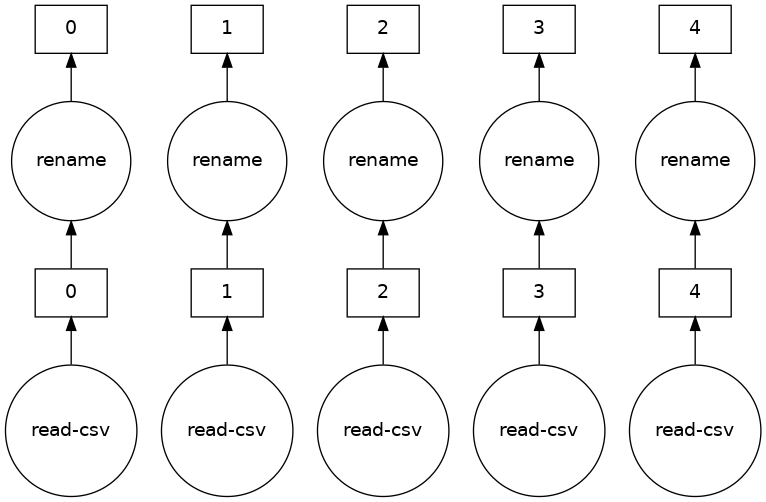

In [12]:
ddf_gpu.visualize()

Here, we can see a number of circles with `read-csv` on them. Each circle is a [partition](https://docs.dask.org/en/latest/dataframe-design.html#dataframe-design-partitions) Dask has automatically assigned to read our data. In other words, we are dividing the work among multiple workers. In this case, it is likely that there is one circle for each file.

For our GPU graph, we have an extra line of code to rename the columns:

`ddf_gpu.columns = ["Date Time", "Water Level", "Sigma"]`

This will show up as an extra node in the graph called `Rename`.

### MapReduce

This is useful not only for reading files, but also for computation. We can assign each of our workers a function to carry out. There are two major types of functions we can assign our workers:

* `Map` is a type of function that can be carried out by each worker individually.
* `Reduce` is a type of function that requires all workers to share information.

Let's work through an example to see this in action.

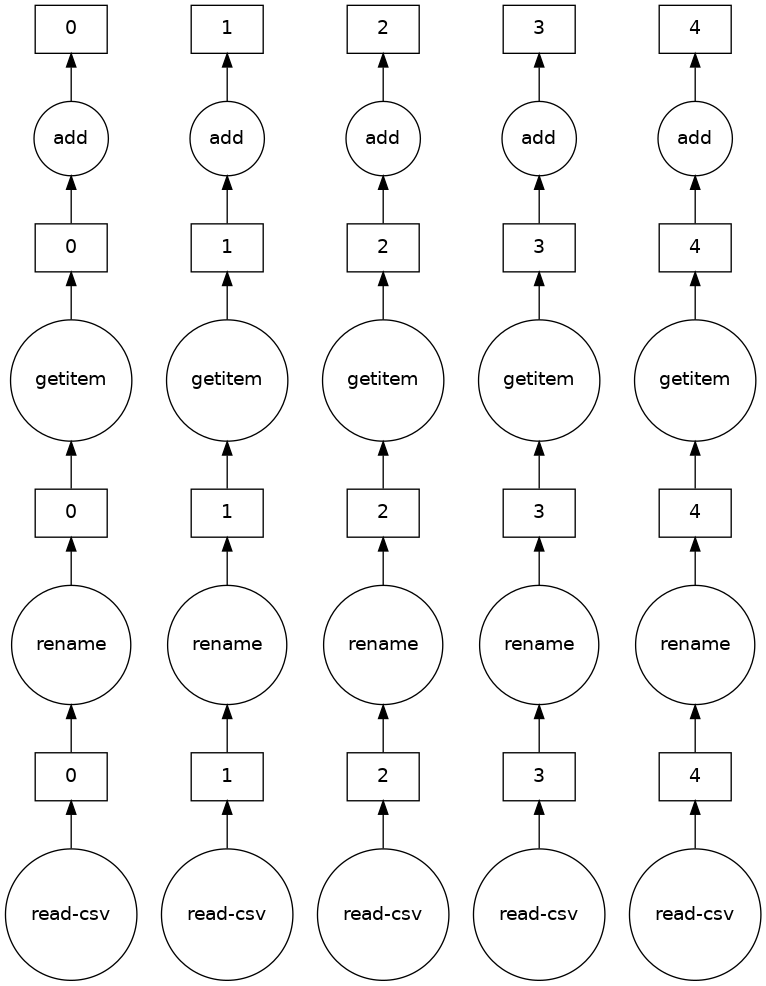

In [13]:
map_water_level = ddf_gpu["Water Level"] + 10
map_water_level.visualize()

In this case, we're adding `10` to the water level. Since each worker does not need to see any of the other worker's data, this would be a `Map` operation.

Alternatively, we can use the [map](https://docs.rapids.ai/api/cudf/stable/api.html#cudf.core.series.Series.map) method to apply our own function.

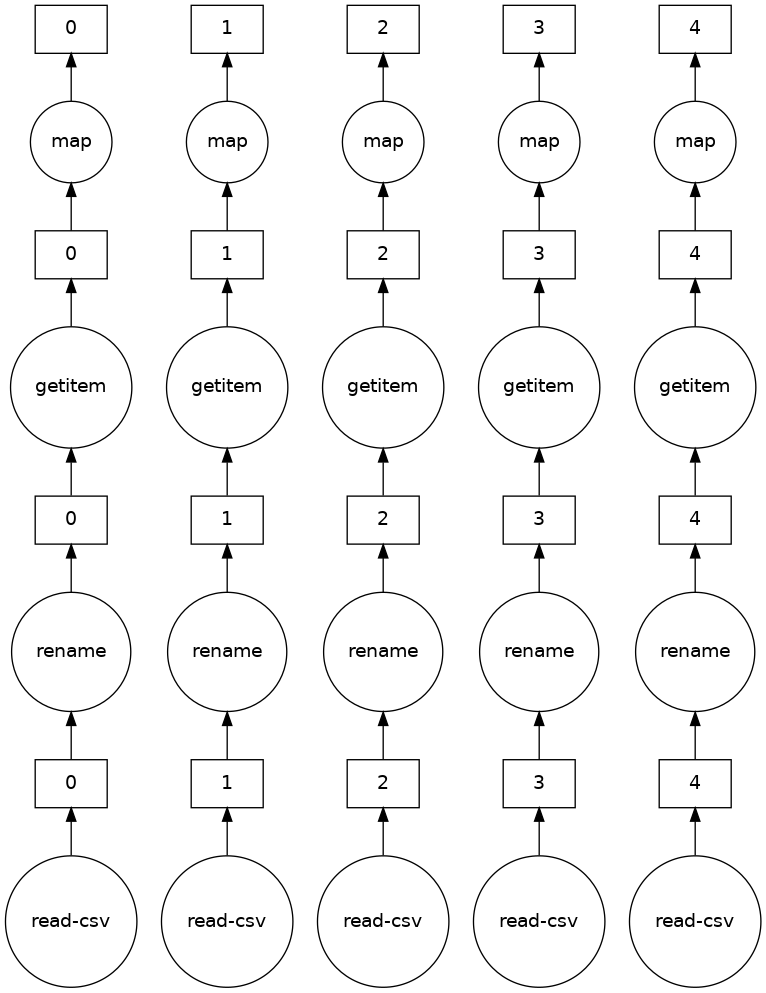

In [14]:
def add_ten(x):
    return x + 10

map_water_level = ddf_gpu["Water Level"].map(add_ten)
map_water_level.visualize()

cuDF has a few built in map functions. For example, if we have an address column and we want to break down its components (street, state/province, country) into multiple columns, we might want to use the [apply_rows](https://docs.rapids.ai/api/cudf/stable/api.html?#cudf.core.dataframe.DataFrame.apply_rows) or [apply_chunks](https://docs.rapids.ai/api/cudf/stable/api.html?#cudf.core.dataframe.DataFrame.apply_chunks) methods. Read more about them in [this article](https://medium.com/rapids-ai/user-defined-functions-in-rapids-cudf-2d7c3fc2728d).

Unlike `Map` functions, `Reduce` functions aggregate data across multiple workers.

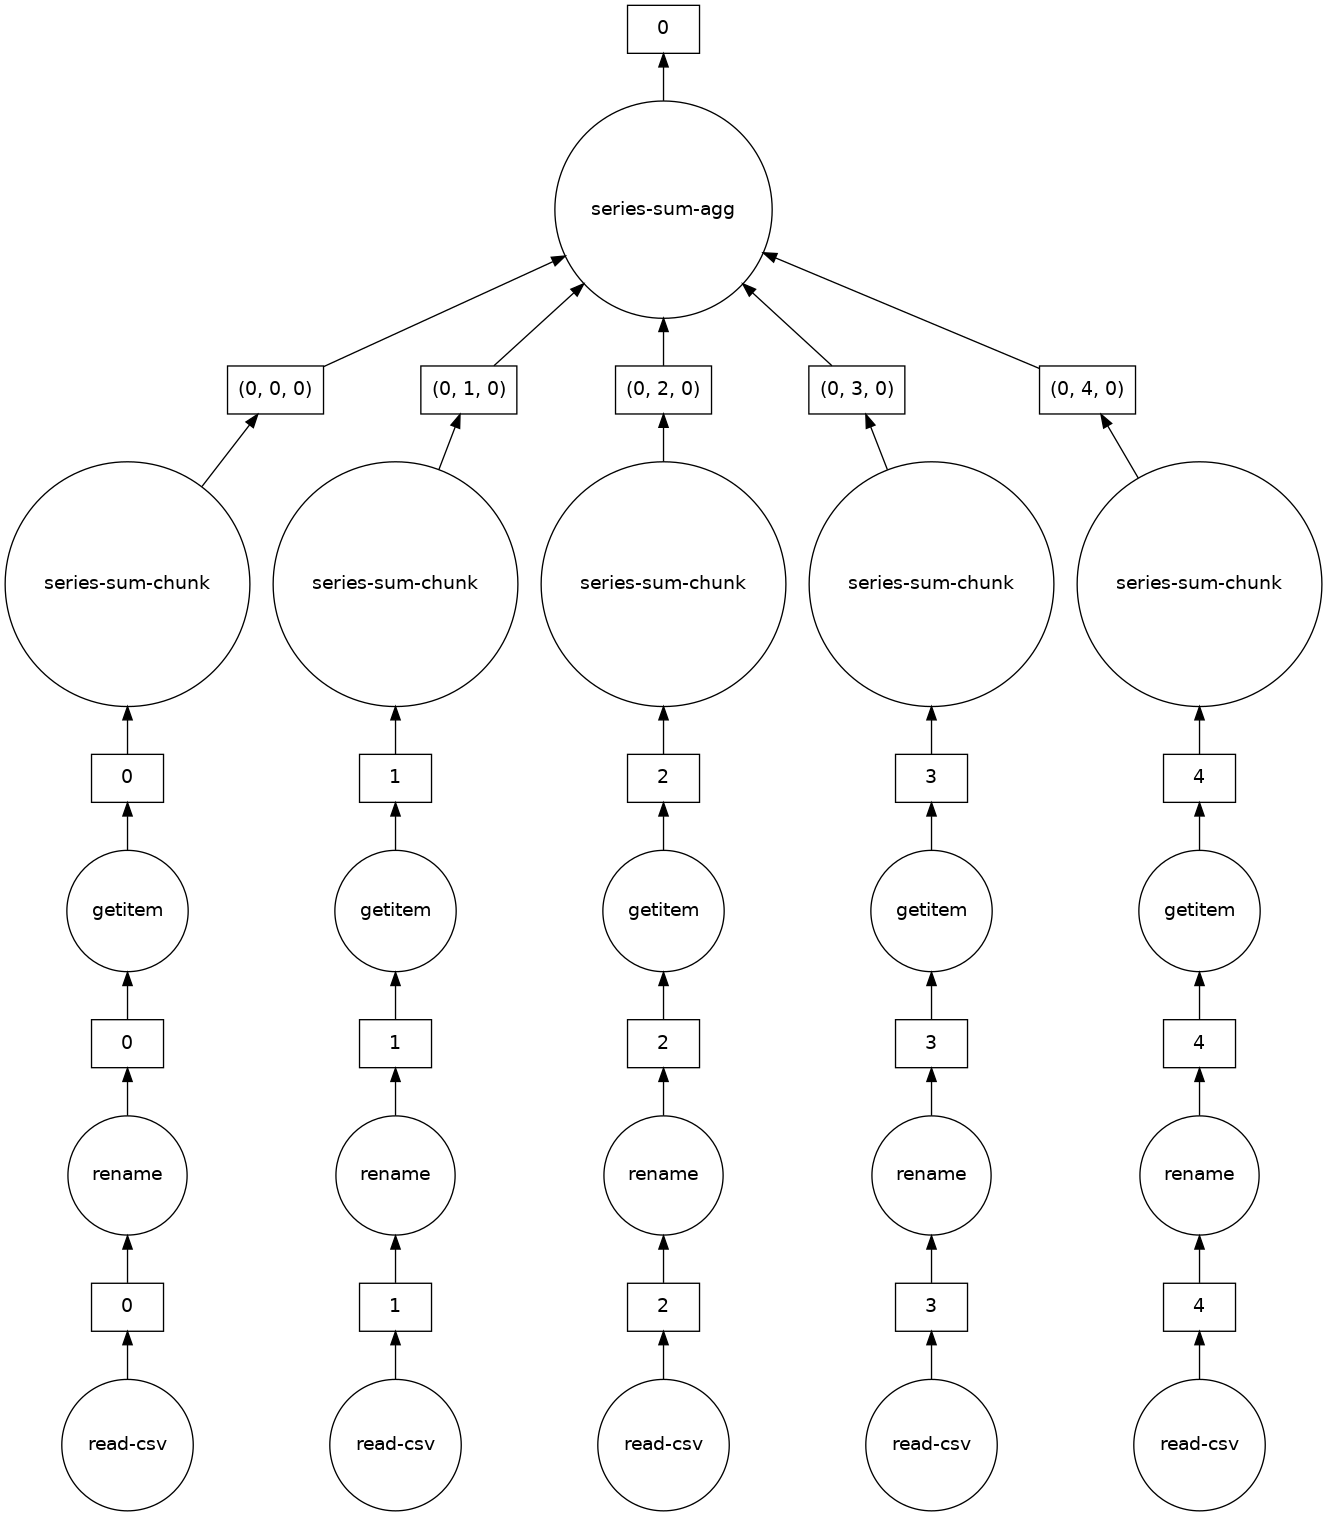

In [15]:
reduce_water_level = ddf_gpu["Water Level"].sum()
reduce_water_level.visualize()

Here, we can see all three workers reduce down to one `series-sum-agg` worker. In order to calculate a sum across all the data, the workers need to communicate to share their data.

Because of this, `Map` functions can run asynchronously, whereas `Reduce` functions force synchronization. If it can be avoided, try to eliminate unnecessary `Reduce` functions to prevent idle workers. Aggregate functions like `sum` are unavoidable and must be done with a `Reduce` step.

We can combine these two functions together to create `MapReduce`.

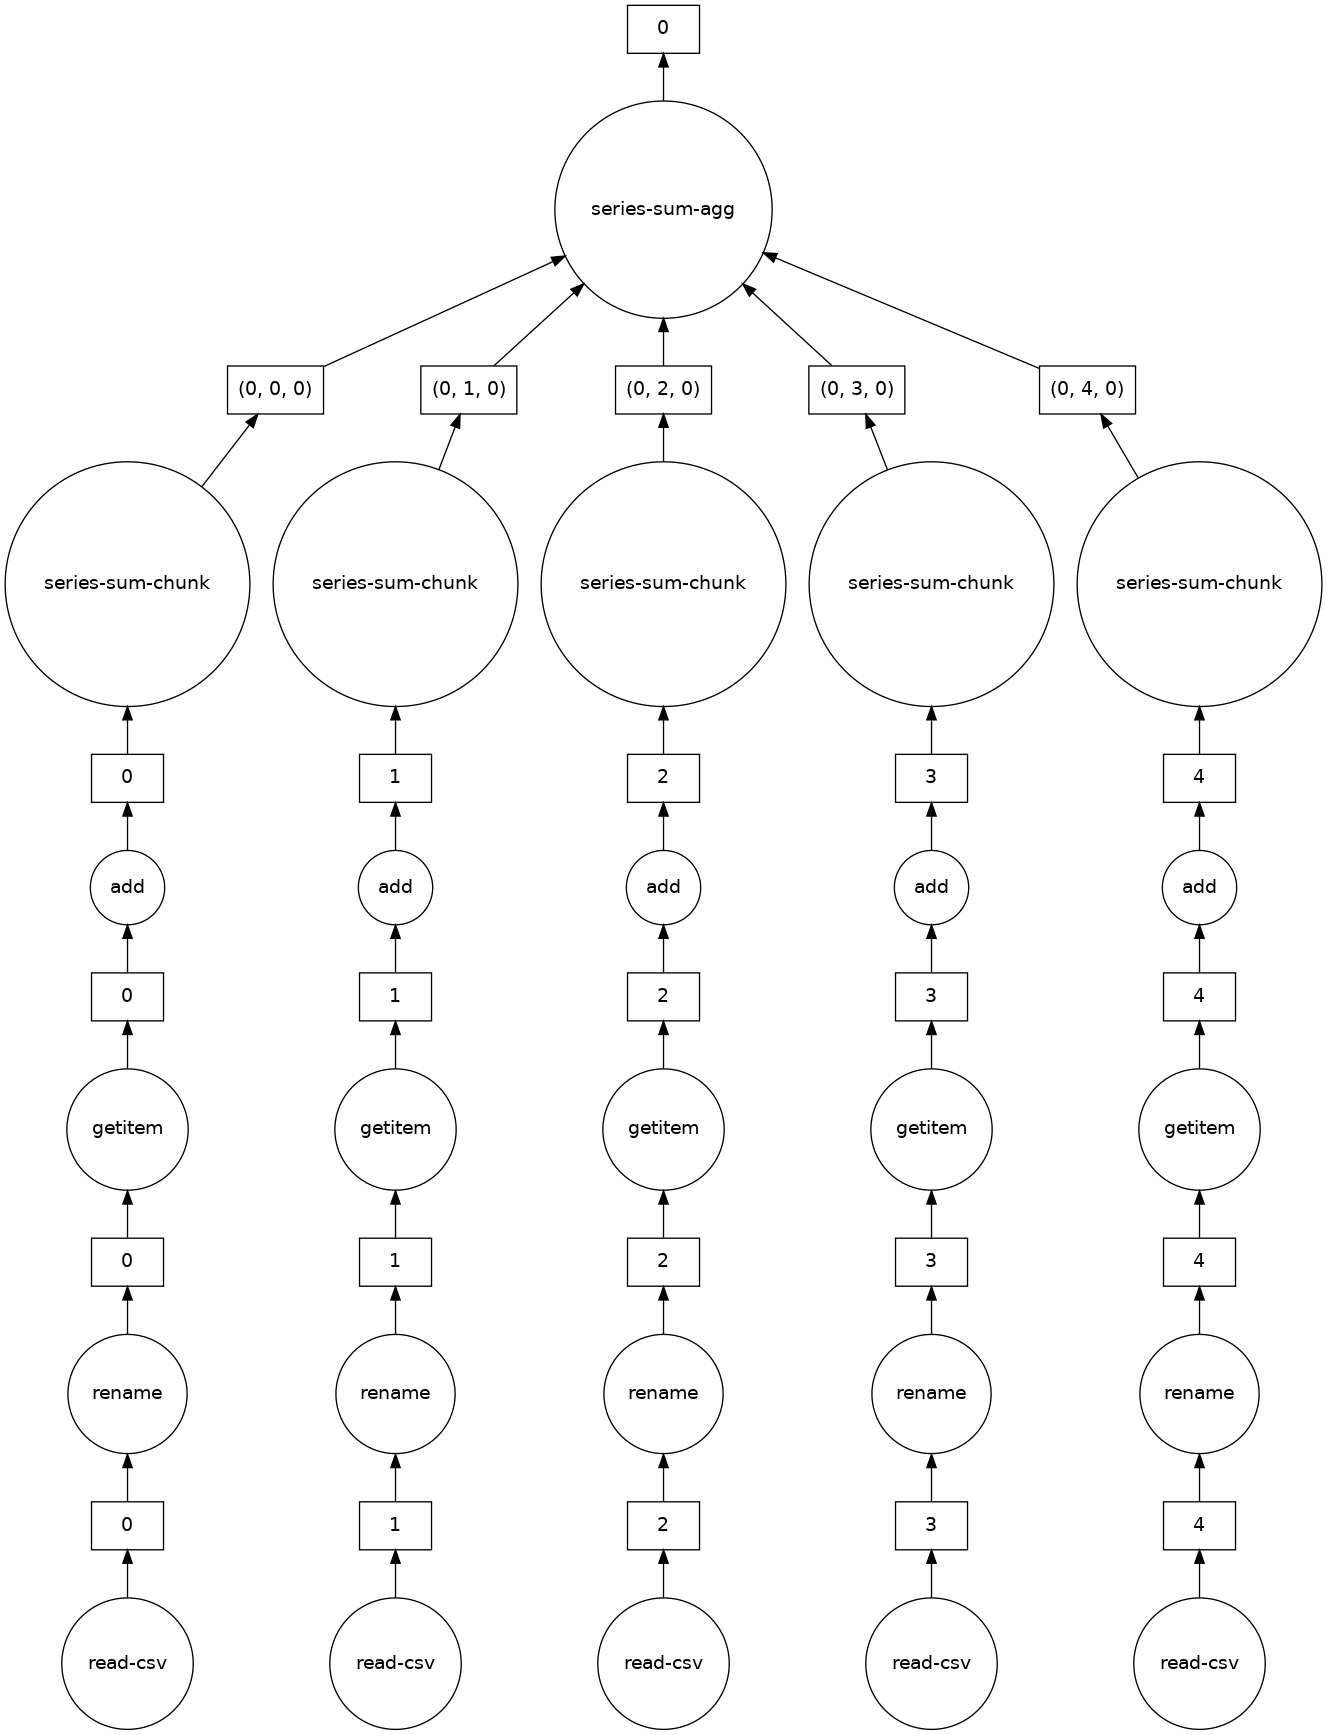

In [16]:
mapreduce_water_level = (ddf_gpu["Water Level"] + 10).sum()
mapreduce_water_level.visualize()

Order matters. If we reverse the operations, we will end up with a different graph:

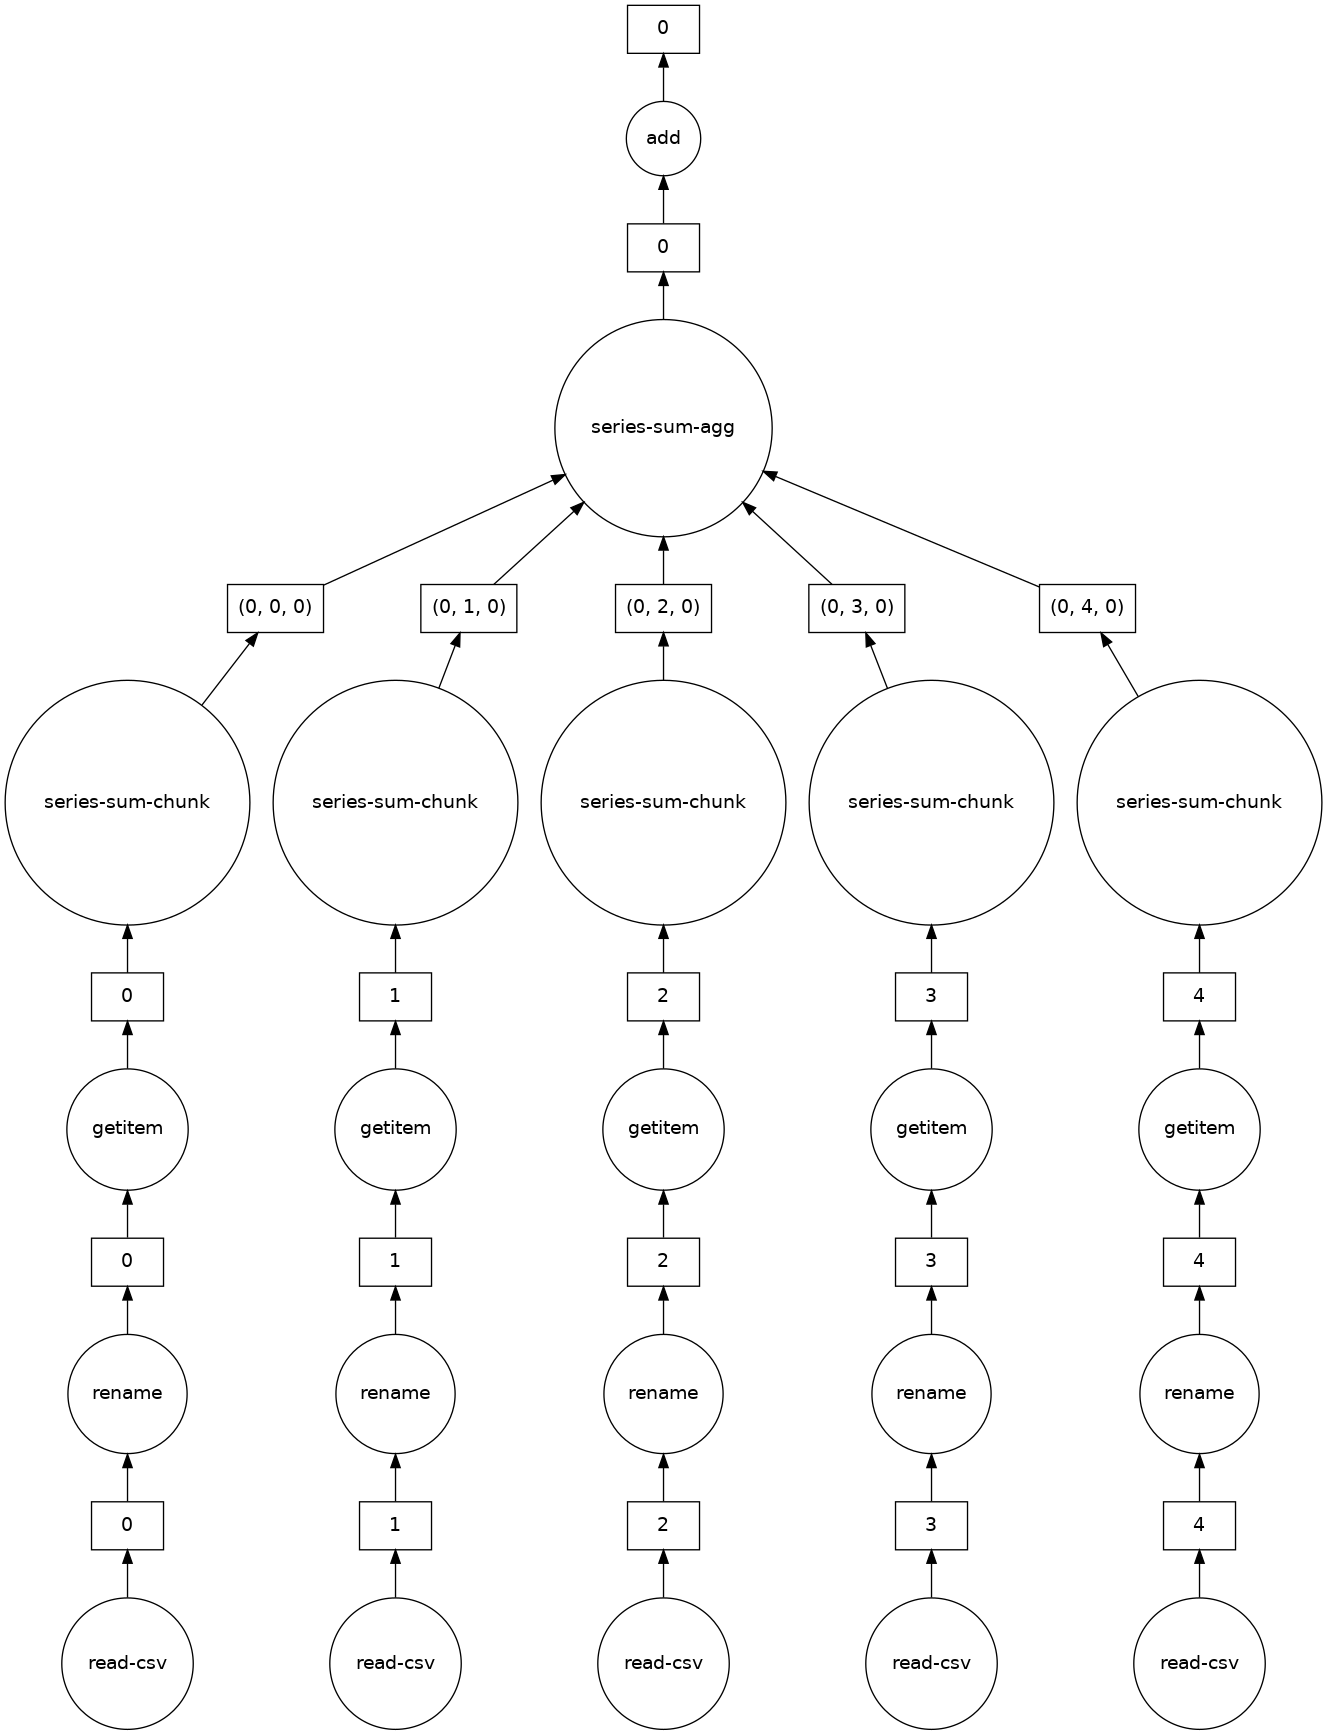

In [17]:
reducemap_water_level = ddf_gpu["Water Level"].sum() + 10
reducemap_water_level.visualize()

### Exercise

Think of your own MapReduce pipeline using `ddf_gpu`. Try to have 2 `Map` functions and 2 `Reduce` functions. We have created an outline below, but feel free to make a structure of your own.

**Hints**:
 * The available columns are `Date Time`, `Water Level`, and `Sigma`
 * Some pandas aggregate functions are [sum](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html), [mean](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html), [min](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html), and [max](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html).

In [ ]:
map1_ddf_gpu = ddf_gpu["Water Level"] FIXME
map2_ddf_gpu = ddf_gpu["Sigma"] FIXME
reduce1_ddf_gpu = map1_ddf_gpu FIXME
reduce2_ddf_gpu = map2_ddf_gpu FIXME
final = reduce1_ddf_gpu + reduce2_ddf_gpu
final.visualize()

In [ ]:
map1_ddf_gpu = ddf_gpu["Water Level"] ** 2
map2_ddf_gpu = ddf_gpu["Sigma"] / 10
reduce1_ddf_gpu = map1_ddf_gpu.sum()
reduce2_ddf_gpu = map2_ddf_gpu.mean()
final = reduce1_ddf_gpu + reduce2_ddf_gpu
final.visualize()

What did your final graph end up looking like? It's interesting that with only six lines of code, we can already build a visually large graph. Want to further test your MapReduce knowledge? Please return to the task launcher to take a short quiz.

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>